In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import butter, lfilter, detrend, hilbert, correlate, convolve, \
    correlation_lags, stft, istft, hann, check_NOLA, check_COLA
from scipy.ndimage import generic_filter
import os


def load_waveform(filepath, apply_detrend=True, return_header=False):
    """
    Read ASCII file created by JSeisLab and create a numpy
    array of dimension [n samples, 2]. Dimension [0,:] is time,
    dimension [1,:] is amplitude
    
    Assumes imports:
        import numpy as np
        from scipy.signal import detrend
    
    filepath (str): directory location of ASCII file
    detrend (bool): detrend signal amplitude
    return_header (bool): optionally return dictionary of
        ASCII file headers
    """
    
    with open(filepath) as f:
        
        ## Read file, skip headers to grab data
        lines = f.readlines()
        wavelines = lines[3:]
        
        ## Gather file headers
        header1 = lines[0]
        header2 = lines[1]
        header1 = header1.split(", ")
        header2 = header2.split(", ")
        headers = {}
        for i in range(len(header1)):
            headers[header1[i]] = header2[i]

        ## Initialize blank array, read each sample from
        ## ASCII file and format into the array
        waveform = np.zeros((2, len(wavelines)))
        for i in range(len(wavelines)):
            waveline = wavelines[i]
            time, amp = waveline.split(", ")
            time = float(time.replace("+", ""))
            amp = float(amp.replace("+", ""))  

            waveform[0, i] = time
            waveform[1, i] = amp

    ## Trigger offset is stored in odd location, grab it
    ## and correct the wavetime
    trigger_offset = float(headers["T outside"]) *1e9
    waveform[0,:] = waveform[0,:] + trigger_offset
    
    ## Detrend amplitude data to remove bias
    if apply_detrend:
        ## Detrended amplitude
        detrend_amp = detrend(waveform[1,:])
        waveform[1,:] = detrend_amp
        
    if return_header:
        return waveform, headers
    else:
        return waveform


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
    
def median(arr, size=5, iterations=1):
    """
    From Bruges library  https://github.com/agilescientific/bruges
    A nonlinear n-D edge-preserving smoothing filter.
    
    Assumes imports:
        import numpy as np
        from scipy.ndimage import generic_filter
    
    Args:
        arr (ndarray): an n-dimensional array, such as a seismic horizon.
        size (int): the kernel size, e.g. 5 for 5x5. Should be odd,
            rounded up if not.
    Returns:
        ndarray: the resulting smoothed array.
    """
    arr = np.array(arr, dtype=float)

    if not size // 2:
        size += 1
    filtered = generic_filter(arr, np.median, size=size)

    return filtered

## Exploring trigger noise

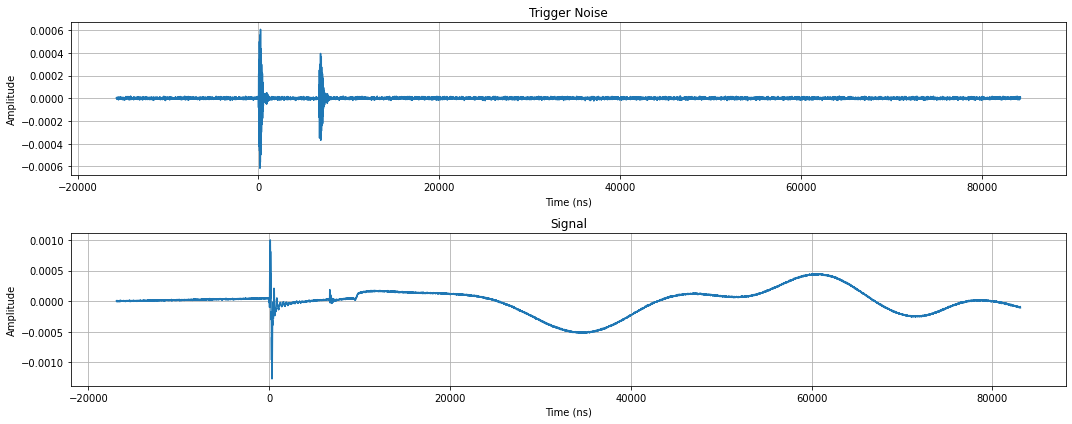

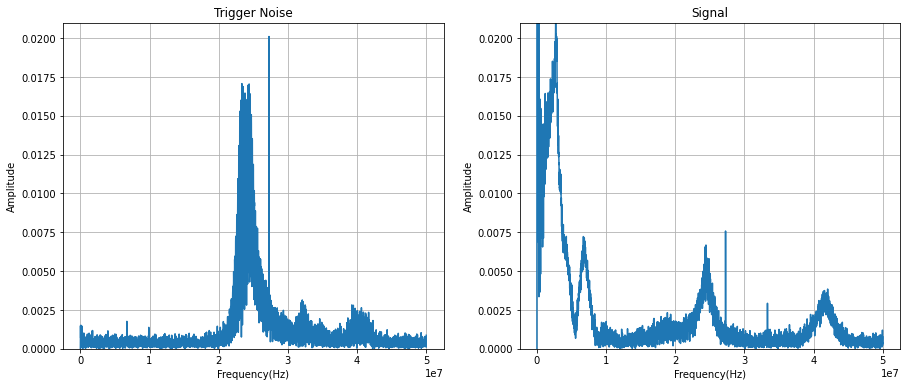

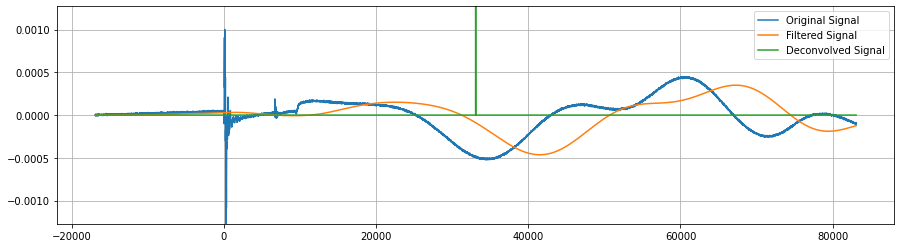

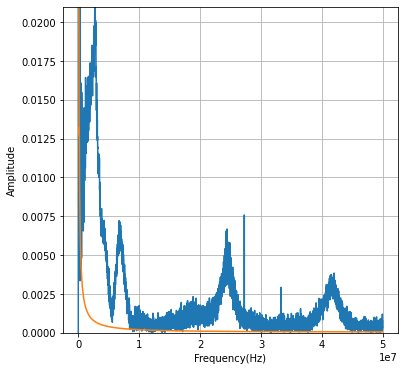

In [3]:
###################
## DEFINE TRIGGER NOISE AND REMOVE
## FROM SIGNAL


## Load data
trig_path = "../Acquisitions/P_measurements/TriggerNoise_P000_0000.asc"
sig_path = "../Acquisitions/P_measurements/10_ice_cemented/1_P_10i_32-1mm_40-04g_P000_0001.asc"

trig_wave, trig_header = load_waveform(trig_path, return_header=True)
sig_wave, sig_header = load_waveform(sig_path, return_header=True)


# ## Trim off first part of signal to remove trigger noise for FFT
# zero_time_idx = np.abs(sig_wave[0,:]).argmin()
# trimmed_signal = sig_wave[:, zero_time_idx+100:]

## Compute rFFT for both signals
trig_sample_rate = 1 / float(trig_header['delta t (s)'])
sig_sample_rate = 1 / float(sig_header['delta t (s)'])

y_trig = rfft(trig_wave[1,:])
x_trig = rfftfreq(len(trig_wave[1,:]), 1 / trig_sample_rate)

y_sig = rfft(sig_wave[1,:])
x_sig = rfftfreq(len(sig_wave[1,:]), 1 / sig_sample_rate)


## Highpass filter trigger noise
lowcut = 0.01e7
highcut = 0.005e7
# filtered_sig = butter_bandpass_filter(sig_wave[1,:], lowcut, highcut, sig_sample_rate, order=3)
filtered_sig = butter_lowpass_filter(sig_wave[1,:], highcut, sig_sample_rate, order=3)
y_filt = rfft(filtered_sig)


## Try deconvolution
# start_decon_noise_win = -2000
# end_decon_noise_win = 10000
# start_decon_noise_idx = (np.abs(trig_wave[0,:] - (start_decon_noise_win))).argmin()
# end_decon_noise_idx = (np.abs(trig_wave[0,:] - (end_decon_noise_win))).argmin()
# decon_noise = trig_wave[1, start_decon_noise_idx:end_decon_noise_idx]
# decon_noise = trig_wave[1,:]
# bias = max(np.amax(np.abs(sig_wave[1,:]) * 1.05), np.amax(np.abs(decon_noise) * 1.05))
# shifted_noise = decon_noise + bias
# shifted_sig = sig_wave[1,:] + bias
# decon,  _ = deconvolve(shifted_sig, shifted_noise)
# n = len(sig_wave[1,:])-len(decon_noise)+1
# s = (len(sig_wave[1,:])-n)//2
# deconv_res = np.zeros(len(sig_wave[1,:]))
# deconv_res[s:len(sig_wave[1,:])-s-1] = decon - bias
# decon = deconv_res


### PLOTS
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 6))
ax[0].plot(trig_wave[0,:], trig_wave[1,:])
# ax[0].axvline(start_decon_noise_win, color='red')
# ax[0].axvline(end_decon_noise_win, color='red')
ax[0].grid("both")
ax[0].set_ylabel("Amplitude")
ax[0].set_xlabel("Time (ns)")
ax[0].set_title("Trigger Noise")

ax[1].plot(sig_wave[0,:], sig_wave[1,:])
ax[1].grid("both")
ax[1].set_ylabel("Amplitude")
ax[1].set_xlabel("Time (ns)")
ax[1].set_title("Signal")

plt.tight_layout()
plt.show()



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
# xlims = (-1e2, 1e5)
ax[0].plot(x_trig, np.abs(y_trig))
# ax[0].set_xlim(1.5e7, 4.5e7)
ax[0].set_ylim(0, 0.021)
ax[0].set_title('Trigger Noise')
ax[0].set_xlabel('Frequency(Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].grid('both')

ax[1].plot(x_sig, np.abs(y_sig))
# ax[1].set_xlim(1.5e7, 4.5e7)
ax[1].set_ylim(0, 0.021)
ax[1].set_title('Signal')
ax[1].set_xlabel('Frequency(Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].grid('both')

plt.show()



plt.figure(figsize=(15, 4))
plt.plot(sig_wave[0,:], sig_wave[1,:], label="Original Signal")
plt.plot(sig_wave[0,:], filtered_sig, label="Filtered Signal")
# plt.plot(sig_wave[0,:], decon, label="Deconvolved Signal")
plt.ylim(-1* np.amax(np.abs(sig_wave[1,:])), np.amax(np.abs(sig_wave[1,:])))
plt.legend()
plt.grid("both")
plt.show()

plt.figure(figsize=(6,6))
plt.plot(x_sig, np.abs(y_sig))
plt.plot(x_sig, np.abs(y_filt))
plt.ylim(0, 0.021)
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amplitude')
plt.grid('both')
plt.show()

NOLA check:  True
COLA check:  True


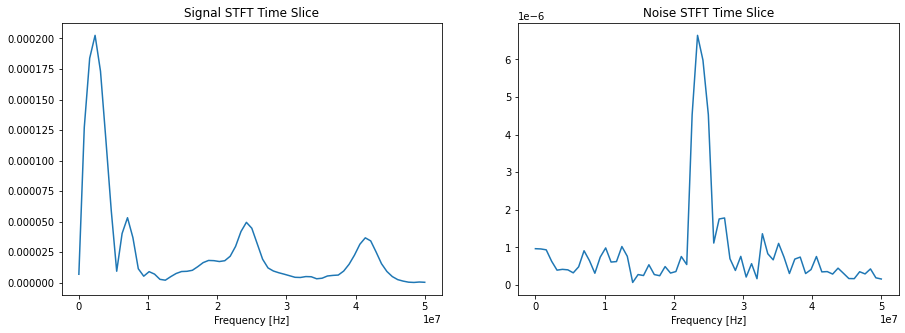

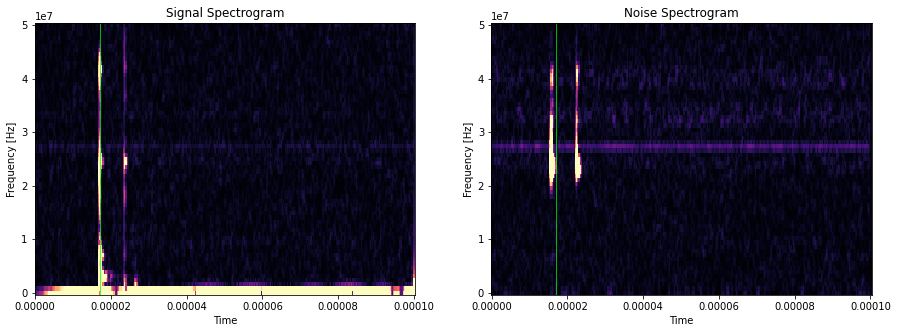

In [54]:
# Zxx parameters
# fs = 1 / 0.0000000375     #sample frequency
nperseg = 128        # nperseg/noverlap combo produces 64x32 assuming 1070 samples
noverlap = 96
window = hann(nperseg, sym=False)

print("NOLA check: ", check_NOLA(window = window, nperseg = nperseg, noverlap = noverlap))
print("COLA check: ", check_COLA(window = window, nperseg = nperseg, noverlap = noverlap))

# Perform STFT
fsig, tsig, ZxxSig = stft(sig_wave[1,:], window = window, fs = sig_sample_rate, 
                          nperseg = nperseg, noverlap=noverlap)
Mag_Sig = np.abs(ZxxSig)
# Mag_2D = np.log(Mag_2D)

fnoise, tnoise, ZxxNoise = stft(trig_wave[1,:], window = window, fs = trig_sample_rate, 
                                nperseg = nperseg, noverlap=noverlap)
Mag_Noise = np.abs(ZxxNoise)


time_display = 0.000017
time_idx = (np.abs(tsig - time_display)).argmin()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(fsig, Mag_Sig[:, time_idx])
ax[0].set_xlabel('Frequency [Hz]')
ax[0].set_title("Signal STFT Time Slice")

ax[1].plot(fnoise, Mag_Noise[:, time_idx])
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_title("Noise STFT Time Slice")
plt.show()

max_display_amp = 1e-5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].pcolormesh(tsig, fsig, Mag_Sig, shading='auto', cmap="magma", vmax=max_display_amp, vmin=0)
ax[0].axvline(time_display, linewidth=0.7, color="lime")
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time')
ax[0].set_title('Signal Spectrogram')

ax[1].pcolormesh(tnoise, fnoise, Mag_Noise, shading='auto', cmap="magma", vmax=max_display_amp, vmin=0)
ax[1].axvline(time_display, linewidth=0.7, color="lime")
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time')
ax[1].set_title('Noise Spectrogram')
plt.show()


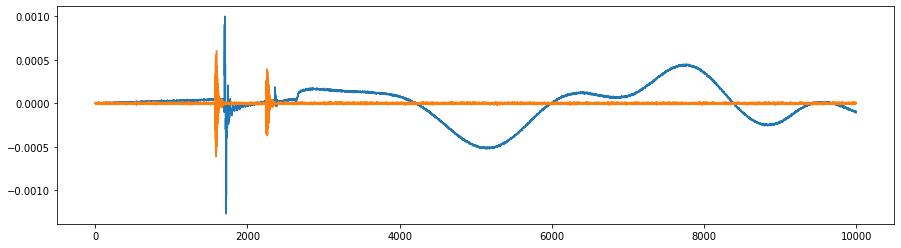

LAG: 124


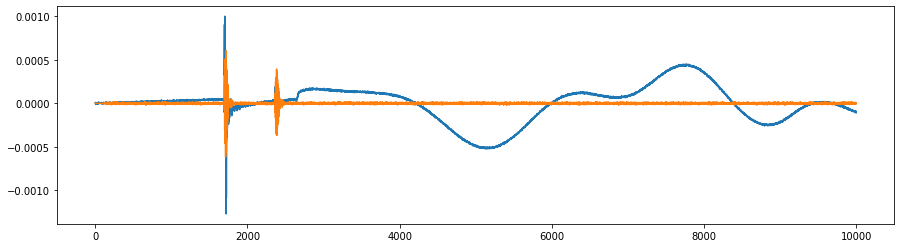

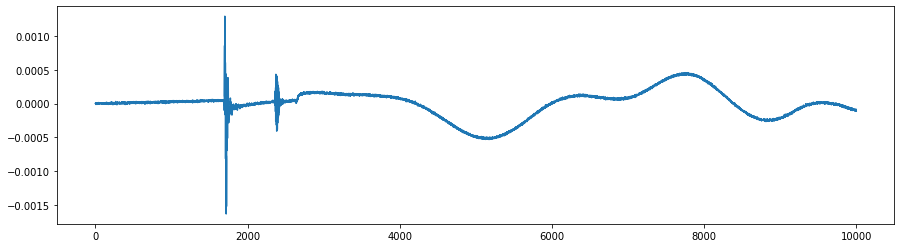

In [30]:
x = np.array(sig_wave[1,:])
y = np.array(trig_wave[1,:])

plt.figure(figsize=(15, 4))
plt.plot(x)
plt.plot(y)
plt.show()


correlation = correlate(x, y, mode="full")
lags = correlation_lags(x.size, y.size, mode="full")
lag = lags[np.argmax(correlation)]

print(f"LAG: {lag}")

shifted_noise = np.pad(y, (lag+1,0))
shifted_noise = shifted_noise[:len(x)]

plt.figure(figsize=(15, 4))
plt.plot(x)
plt.plot(shifted_noise)
plt.show()

subtracted = x - shifted_noise
plt.figure(figsize=(15, 4))
plt.plot(subtracted)
plt.show()

In [ ]:
###################
## FREQUENCY FILTERING

sig_path = "../Acquisitions/P_measurements/0_ice_granular/LightPack/10_P_0i_13-55mm_18-89g_P000_0000.asc"

sig_wave, sig_header = load_waveform(sig_path, return_header=True)

## Trim 100 first 100 samples after zero-time to eliminate
## trigger noise
zero_time_idx = np.abs(sig_wave[0,:]).argmin()
trimmed_amplitudes = sig_wave[1,:][zero_time_idx+100 :]
# trimmed_amplitudes = detrend_amps[zero_time_idx:]  ## altered for H2H


## Plot FFT of trimmed waveform
sample_rate = 1 / float(sig_header['delta t (s)'])
num_samples = len(trimmed_amplitudes)

yf = rfft(trimmed_amplitudes)
xf = rfftfreq(num_samples, 1 / sample_rate)

peak_freq = xf[np.argmax(np.abs(yf))]

plt.figure(figsize=(8,5))
plt.plot(xf, np.abs(yf))
plt.xlim(-1e2, 1e5)
plt.title(f"Peak Frequency: {round(peak_freq)} Hz")
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amplitude')
plt.grid('both')
plt.show() 




## Dominant frequency determined from H2H is ~ 28 kHz
## with a +/- 5 kHz rolloff. Design a filter to only keep
## this dominant bandwidth plus some fluff

lowcut = 10000.
highcut = 30000.

## Detrended input
detrend_amps = detrend(amplitudes)

filtered_signal = butter_bandpass_filter(detrend_amps, lowcut, highcut, sample_rate, order=1)


plt.figure(figsize=(15,4))
plt.plot(wave_time, detrend_amps, label="Recorded")
plt.plot(wave_time, filtered_signal, label="Filtered")
plt.grid("both")
plt.ylabel("Amplitude")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

zoom_left = 50000
zoom_right = 150000
plt.figure(figsize=(8,8))
plt.plot(wave_time, detrend_amps, label="Recorded")
plt.plot(wave_time, filtered_signal, label="Filtered")
plt.grid("both")
plt.ylabel("Amplitude")
plt.xlabel("Time (ns)")
plt.xlim(zoom_left, zoom_right)
plt.legend()
plt.show()

In [ ]:
analytic_signal = hilbert(detrend_amps)
analytic_signal_filt = hilbert(filtered_signal)

plt.figure(figsize=(15,4))
plt.plot(wave_time, detrend_amps, label="Recorded", color="blue")
plt.plot(wave_time, np.abs(analytic_signal), ls=":", color="blue")
plt.plot(wave_time, filtered_signal, label="Filtered", color="red")
plt.plot(wave_time, np.abs(analytic_signal_filt), ls=":", color="red")
plt.grid("both")
plt.ylabel("Amplitude")
plt.xlabel("Time (ns)")
plt.legend()
plt.show()

# Vacuum

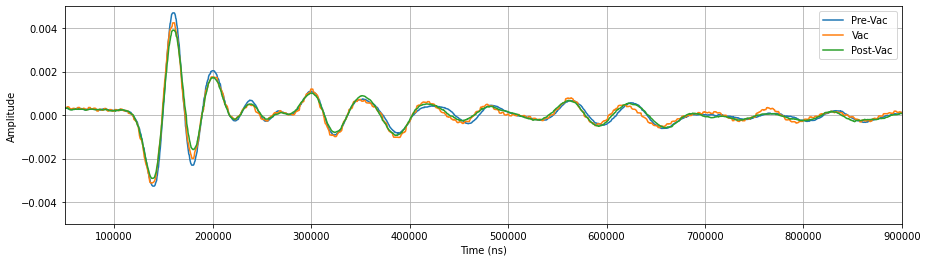

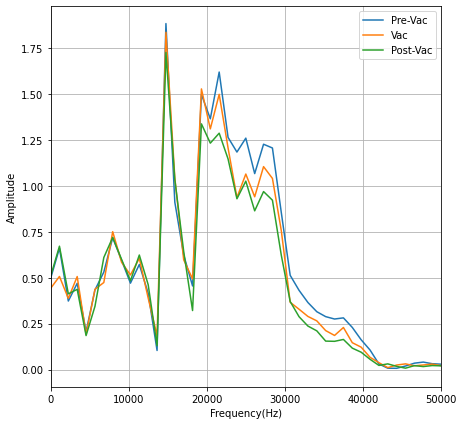

In [4]:
### -----------------------------------------
### Compare P frequency spectra of vacuum test

## Define filepaths
file0 = "../Acquisitions/P_measurements/0_ice_Vacuum/1_P_0i_20-4mm_30-45g_P000_0000.asc"
file1 = file0.split(".asc")[0][:-1]+"1.asc"
file2 = file0.split(".asc")[0][:-1]+"2.asc"

## Load saved waveforms
wave0, wave0_header = load_waveform(file0, return_header=True)
wave1, wave1_header = load_waveform(file1, return_header=True)
wave2, wave2_header = load_waveform(file2, return_header=True)

## Grab time values, optionally smooth amplitudes and
## trim trigger noise
sig_start = 50000  #start time in ns, None for no trim
smoother = 40  # None for no smoothing

wave0_time = wave0[0,:]
wave1_time = wave1[0,:]
wave2_time = wave2[0,:]
if sig_start is not None:
    sig_start_idx = (np.abs(sig_start - wave0_time)).argmin()
    wave0_time = wave0_time[sig_start_idx:]
    wave1_time = wave1_time[sig_start_idx:]
    wave2_time = wave2_time[sig_start_idx:]
    
wave0_amp = wave0[1,:]
wave1_amp = wave1[1,:]
wave2_amp = wave2[1,:]
if smoother is not None:
    wave0_amp = median(wave0_amp, size=smoother)
    wave1_amp = median(wave1_amp, size=smoother)
    wave2_amp = median(wave2_amp, size=smoother)
if sig_start is not None:
    wave0_amp = wave0_amp[sig_start_idx:]
    wave1_amp = wave1_amp[sig_start_idx:]
    wave2_amp = wave2_amp[sig_start_idx:]

## Plot waveforms
plt.figure(figsize=(15,4))
plt.plot(wave0_time, wave0_amp, label="Pre-Vac")
plt.plot(wave1_time, wave1_amp, label="Vac")
plt.plot(wave2_time, wave2_amp, label="Post-Vac")
plt.grid("both")
plt.ylabel("Amplitude")
plt.xlabel("Time (ns)")
plt.xlim(50000,900000)
plt.ylim(-0.005, 0.005)
plt.legend()
plt.show()



## Compute rFFT for signals
wave0_sample_rate = 1 / float(wave0_header['delta t (s)'])
wave1_sample_rate = 1 / float(wave1_header['delta t (s)'])
wave2_sample_rate = 1 / float(wave2_header['delta t (s)'])

y_wave0 = rfft(wave0_amp)
x_wave0 = rfftfreq(len(wave0_amp), 1 / wave0_sample_rate)
y_wave1 = rfft(wave1_amp)
x_wave1 = rfftfreq(len(wave1_amp), 1 / wave1_sample_rate)
y_wave2 = rfft(wave2_amp)
x_wave2 = rfftfreq(len(wave2_amp), 1 / wave2_sample_rate)

## Plot frequency spectra
plt.figure(figsize=(7,7))
plt.plot(x_wave0, np.abs(y_wave0), label="Pre-Vac")
plt.plot(x_wave1, np.abs(y_wave1), label="Vac")
plt.plot(x_wave2, np.abs(y_wave2), label="Post-Vac")
plt.xlabel('Frequency(Hz)')
plt.ylabel('Amplitude')
plt.grid('both')
plt.xlim(0, 5e4)
plt.legend()
plt.show()

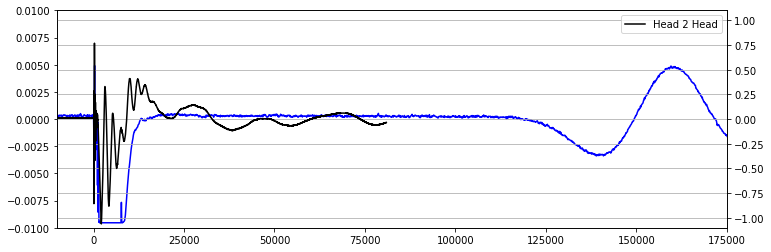

In [48]:
## Plot an example waveform along with head2head

file0 = "../Acquisitions/P_measurements/0_ice_Vacuum/1_P_0i_20-4mm_30-45g_P000_0000.asc"
wave0 = load_waveform(file0)
wave0_time = wave0[0,:]
wave0_amp = wave0[1,:]

h2h = "../Acquisitions/P_measurements/0_ice_Vacuum/Head2Head_NoVac_P000_0000.asc"
h2h_pre = load_waveform(h2h)
h2h_time = h2h_pre[0,:]
h2h_amp = h2h_pre[1,:]

fig, ax1 = plt.subplots(figsize=(12,4))
ax2 = ax1.twinx()
xlims = (-1e4, 1.75e5)
ax1.plot(wave0_time, wave0_amp, color='blue', label="Example waveform")
ax1.set_xlim(xlims[0], xlims[1])
ax1.set_ylim(-0.01, 0.01)

ax2.plot(h2h_time, h2h_amp, color="black", label="Head 2 Head")
ax2.set_xlim(xlims[0], xlims[1])
ax2.set_ylim(-1.1, 1.1)

plt.grid(which="both")
plt.legend()
plt.show()

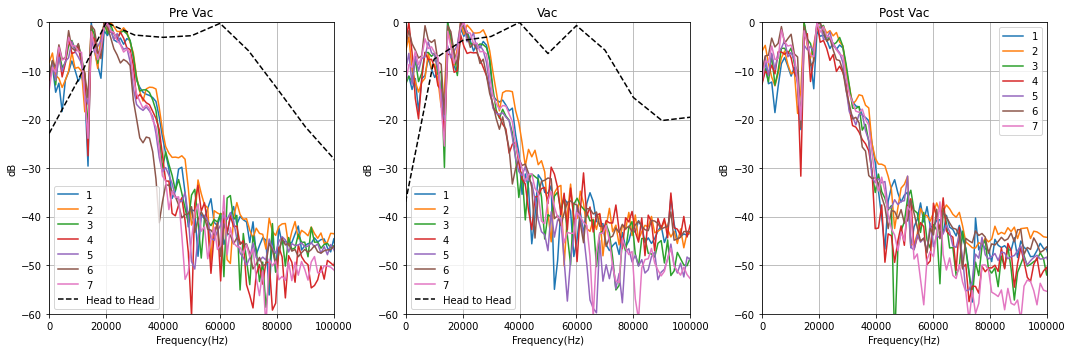

In [30]:
## Load all vac P data

vac_dir = "../Acquisitions/P_measurements/0_ice_Vacuum/"
vac_data = {}
sig_start = 50000  #start time in ns, None for no trim
smoother = 20  # None for no smoothing
highcut = 75000  # None for no filtering

for root, dirs, files in os.walk(vac_dir):
    for file in files:
        if file.endswith(".asc") and file[0].isdigit():
            pass
        else:
            continue
            
        if file[0] in vac_data.keys():
            pass
        else:
            vac_data[file[0]] = {}
            vac_data[file[0]]["pre"] = {}
            vac_data[file[0]]["vac"] = {}
            vac_data[file[0]]["post"] = {}
        
        tmp_wave, tmp_header = load_waveform(os.path.join(root, file), return_header=True)
        
        tmp_time = tmp_wave[0,:]
        if sig_start is not None:
            sig_start_idx = (np.abs(sig_start - tmp_time)).argmin()
            tmp_time = tmp_time[sig_start_idx:]
            
        tmp_amp = tmp_wave[1,:]
        if highcut is not None:
            sample_rate = 1 / float(tmp_header['delta t (s)'])
            tmp_amp = butter_lowpass_filter(tmp_amp, highcut, sample_rate, order=5)
        if smoother is not None:
            tmp_amp = median(tmp_amp, size=smoother)
        if sig_start is not None:
            tmp_amp = tmp_amp[sig_start_idx:]
        
        _tmp1 = int(file.split(".")[0][-1])
        _tmp2 = ["pre", "vac", "post"]
        
        vac_data[file[0]][_tmp2[_tmp1]]["time"] = tmp_time
        vac_data[file[0]][_tmp2[_tmp1]]["amp"] = tmp_amp
        vac_data[file[0]][_tmp2[_tmp1]]["header"] = tmp_header
        
## Head2Head
h2h_pre_path = os.path.join(vac_dir, "Head2Head_NoVac_P000_0000.asc")
h2h_vac_path = os.path.join(vac_dir, "Head2Head_Vac_P000_0000.asc")

h2h_pre, h2h_pre_header = load_waveform(h2h_pre_path, return_header=True)
h2h_vac, h2h_vac_header = load_waveform(h2h_vac_path, return_header=True)

sig_start = None

h2h_pre_time = h2h_pre[0,:]
h2h_vac_time = h2h_vac[0,:]
if sig_start is not None:
    sig_start_idx_pre = (np.abs(sig_start - h2h_pre_time)).argmin()
    h2h_pre_time = h2h_pre_time[sig_start_idx_pre:]
    sig_start_idx_vac = (np.abs(sig_start - h2h_vac_time)).argmin()
    h2h_vac_time = h2h_vac_time[sig_start_idx_vac:]
    

h2h_pre_amp = h2h_pre[1,:]
h2h_vac_amp = h2h_vac[1,:]
if highcut is not None:
    sample_rate_pre = 1 / float(h2h_pre_header['delta t (s)'])
    h2h_pre_amp = butter_lowpass_filter(h2h_pre_amp, highcut, sample_rate_pre, order=5)
    sample_rate_vac = 1 / float(h2h_vac_header['delta t (s)'])
    h2h_vac_amp = butter_lowpass_filter(h2h_vac_amp, highcut, sample_rate_vac, order=5)
if smoother is not None:
    h2h_pre_amp = median(h2h_pre_amp, size=smoother)
    h2h_vac_amp = median(h2h_vac_amp, size=smoother)
if sig_start is not None:
    h2h_pre_amp = tmp_amp[sig_start_idx_pre:]
    h2h_vac_amp = tmp_amp[sig_start_idx_vac:]
        
        
## Plot frequency spec of all runs
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for key in vac_data.keys():
    for i in np.arange(3):
        sample_rate = 1 / float(vac_data[key][_tmp2[i]]["header"]['delta t (s)'])
        amp = vac_data[key][_tmp2[i]]["amp"]
        
        x = rfftfreq(len(amp), 1 / sample_rate)
        y = rfft(amp)
        y_db = 20 * np.log10(np.abs(y)/max(np.abs(y)))

        ax[i].plot(x, y_db, label=key)
        
ax[0].plot(rfftfreq(len(h2h_pre_amp), 1 / sample_rate_pre),
          20 * np.log10(np.abs(rfft(h2h_pre_amp))/max(np.abs(rfft(h2h_pre_amp)))),
          label="Head to Head",
          ls="--",
          color="black")

ax[1].plot(rfftfreq(len(h2h_vac_amp), 1 / sample_rate_vac),
          20 * np.log10(np.abs(rfft(h2h_vac_amp))/max(np.abs(rfft(h2h_vac_amp)))),
          label="Head to Head",
          ls="--",
          color="black")
        
for i in np.arange(3):
    ax[i].grid('both')
    ax[i].set_xlabel('Frequency(Hz)')
    ax[i].set_ylabel('dB')
    ax[i].set_xlim(0, 1e5)
    ax[i].set_ylim(-60, 0)
    ax[i].legend()
ax[0].set_title("Pre Vac")
ax[1].set_title("Vac")
ax[2].set_title("Post Vac")
    
plt.tight_layout()
plt.show()

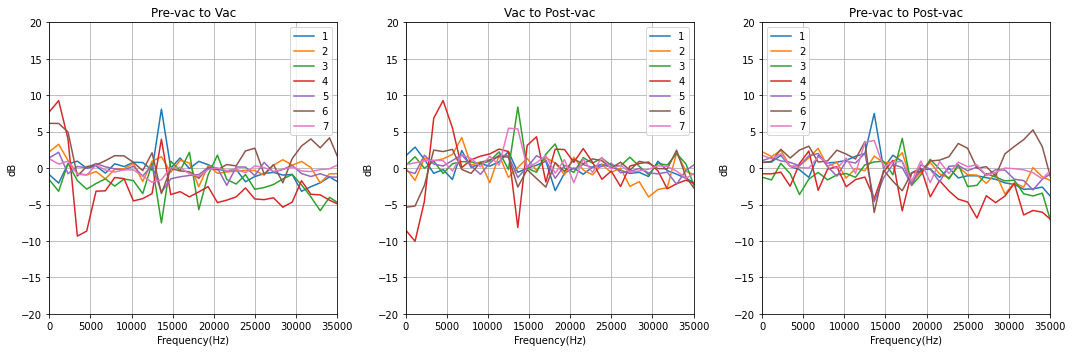

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for key in vac_data.keys():
    dbs = []
    for i in np.arange(3):
        sample_rate = 1 / float(vac_data[key][_tmp2[i]]["header"]['delta t (s)'])
        amp = vac_data[key][_tmp2[i]]["amp"]
        
        x = rfftfreq(len(amp), 1 / sample_rate)
        y = rfft(amp)
        y_db = 20 * np.log10(np.abs(y)/max(np.abs(y)))
        
        dbs.append(y_db)
        
    up_vac = dbs[1] - dbs[0]
    down_vac = dbs[2] - dbs[1]
    de_vac = dbs[2] - dbs[0]
    
    ax[0].plot(x, up_vac, label=key)
    ax[1].plot(x, down_vac, label=key)
    ax[2].plot(x, de_vac, label=key)
    
for i in np.arange(3):
    ax[i].grid('both')
    ax[i].set_xlabel('Frequency(Hz)')
    ax[i].set_ylabel('dB')
    ax[i].set_xlim(0, 3.5e4)
    ax[i].set_ylim(-20, 20)
    ax[i].legend()
    
ax[0].set_title("Pre-vac to Vac")
ax[1].set_title("Vac to Post-vac")
ax[2].set_title("Pre-vac to Post-vac")
    
plt.tight_layout()
plt.show()

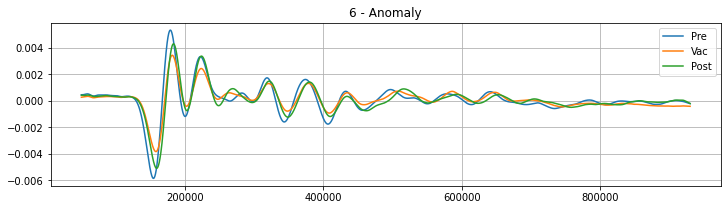

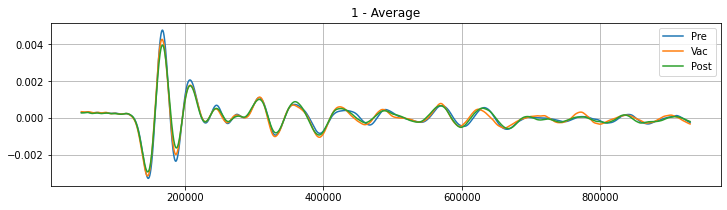

In [29]:
plt.figure(figsize=(12,3))
plt.plot(vac_data['6']['pre']['time'],
        vac_data['6']['pre']['amp'],
        label="Pre")
plt.plot(vac_data['6']['vac']['time'],
        vac_data['6']['vac']['amp'],
        label="Vac")
plt.plot(vac_data['6']['post']['time'],
        vac_data['6']['post']['amp'],
        label="Post")
plt.title("6 - Anomaly")
plt.grid("both")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(vac_data['1']['pre']['time'],
        vac_data['1']['pre']['amp'],
        label="Pre")
plt.plot(vac_data['1']['vac']['time'],
        vac_data['1']['vac']['amp'],
        label="Vac")
plt.plot(vac_data['1']['post']['time'],
        vac_data['1']['post']['amp'],
        label="Post")
plt.title("1 - Average")
plt.grid("both")
plt.legend()
plt.show()